# Tutorial : Persian Sentiment Analysis With LSTM & Fasttext
### step by step guide through Persian sentiment analysis


---


so there are 4 steps we going through with each other  😍

## Step A) Preparing word embedding model
in this step we gonna to prepare [word embedding](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) model.
there are too many ways to train a word embedding model for example :

1.   Fasttext
2.   ELMo
3.   Universal Sentence Embeddings ( 😂 این یکی عالیه )
4.   Word2Vec
5.   ...

if you Want to know more then read [this article from Thomas Wolf](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a) but now we gonna use Fasttext because it's Pretrained by Facebook and we can use it ( there is nothing to worry about this model it's pretty easy to train it by your self or your corpus facebook used Persian Wikipedia and some other staff as dataset for this model so it's just very simpler for us 😎 )



In [1]:
#@title Download, extract and load Fasttext word embedding model

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
!gunzip /content/cc.fa.300.bin.gz
!pip install fasttext

import fasttext 

%time
model = fasttext.load_model("/content/cc.fa.300.bin")

--2022-01-31 03:30:08--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4502524724 (4.2G) [application/octet-stream]
Saving to: ‘cc.fa.300.bin.gz’

cc.fa.300.bin.gz    100%[===================>]   4.19G  51.0MB/s    in 86s     

2022-01-31 03:31:34 (50.2 MB/s) - ‘cc.fa.300.bin.gz’ saved [4502524724/4502524724]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


## Step B) Preparing opinion dataset
in this step we going to collect a dataset that crawled by [@minasmz](https://github.com/minasmz) it's not good and I only used 450 pos and 450 neg reviews from it.anyway here we will download the dataset and split it to train and test ( I created Train and Test then I filled it with data )

In [2]:
#@title Download and prepare Dataset
!wget https://raw.githubusercontent.com/ashalogic/Persian-Sentiment-Analyzer/master/Tutorial_Dataset.csv
!pip install hazm

import pandas
import random
import numpy
import hazm

def CleanPersianText(text):
  _normalizer = hazm.Normalizer()
  text = _normalizer.normalize(text)
  return text

csv_dataset = pandas.read_csv("/content/Tutorial_Dataset.csv")
revlist = list(map(lambda x: [CleanPersianText(x[0]),x[1]],zip(csv_dataset['Text'],csv_dataset['Suggestion'])))
pos=list(filter(lambda x: x[1] == 1,revlist))
nat=list(filter(lambda x: x[1] == 2,revlist))
neg=list(filter(lambda x: x[1] == 3,revlist))
revlist_shuffle = pos[:450] + neg[:450]
random.shuffle(revlist_shuffle)

print("Posetive count {}".format(len(pos)))
print("Negetive count {}".format(len(neg)))
print("Natural  count {}".format(len(nat)))
print()
print("Total    count {}".format(len(revlist)))
print()
print("Posetive count : ","\n",pos[random.randrange(1,len(pos))])
print("Negetive count : ","\n",neg[random.randrange(1,len(neg))])
print("unknown  count : ","\n",nat[random.randrange(1,len(nat))])
print("Total    count {}".format(len(revlist_shuffle)))


--2022-01-31 03:35:59--  https://raw.githubusercontent.com/ashalogic/Persian-Sentiment-Analyzer/master/Tutorial_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1444954 (1.4M) [text/plain]
Saving to: ‘Tutorial_Dataset.csv’

Tutorial_Dataset.cs 100%[===================>]   1.38M  --.-KB/s    in 0.06s   

2022-01-31 03:36:00 (24.7 MB/s) - ‘Tutorial_Dataset.csv’ saved [1444954/1444954]

Posetive count 2382
Negetive count 460
Natural  count 419

Total    count 3261

Posetive count :  
 ['فوق العاده حس کنسرت رو بهت میده بیس بالا حتما بخرید پشیمون نمیشید ', 1]
Negetive count :  
 ['کیفیتس خوبه و بسته بندی زیبایی داره از دیجی کالا هم ممنون ', 3]
unknown  count :  
 ['این کرم برای کسایی خوبه که پوستشون سفید یا گندمیه روشنه و اینکه خیلی رقیقه روی پوست سبکه

In [3]:
#@title Prepare Train & Test Data
vector_size = 300 #@param {type:"integer"}
max_no_tokens = 20 #@param {type:"integer"}
import numpy as np
import keras.backend as K
train_size = int(0.9*(len(revlist_shuffle)))
test_size = int(0.1*(len(revlist_shuffle)))

indexes = set(np.random.choice(len(revlist_shuffle), train_size + test_size, replace=False))

x_train = np.zeros((train_size, max_no_tokens, vector_size), dtype=K.floatx())
y_train = np.zeros((train_size, 2), dtype=np.int32)

x_test = np.zeros((test_size, max_no_tokens, vector_size), dtype=K.floatx())
y_test = np.zeros((test_size, 2), dtype=np.int32)

In [4]:
#@title Fill X_Train, X_Test, Y_Train, Y_Test with Dataset
for i, index in enumerate(indexes):
  text_words = hazm.word_tokenize(revlist_shuffle[index][0])
  for t in range(0,len(text_words)):
    if t >= max_no_tokens:
      break
    
    if text_words[t] not in model.words:
      continue
    if i < train_size:
      x_train[i, t, :] = model.get_word_vector(text_words[t])
    else:
      x_test[i - train_size, t, :] = model.get_word_vector(text_words[t])

  if i < train_size:
    y_train[i, :] = [1.0, 0.0] if revlist_shuffle[index][1] == 3 else [0.0, 1.0]
  else:
    y_test[i - train_size, :] = [1.0, 0.0] if revlist_shuffle[index][1] == 3 else [0.0, 1.0]
    
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((810, 20, 300), (90, 20, 300), (810, 2), (90, 2))

## Step C) Preparing LSTM model
Now we will create our LSTM model then feed it our Train data and boom!

In [5]:
#@title Set batchSize and epochs
batch_size = 500 #@param {type:"integer"}
no_epochs =  200 #@param {type:"integer"}
w2v_model = model
del model

In [6]:
#@title Building LSTM Model
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard


model = Sequential()

model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same',
                 input_shape=(max_no_tokens, vector_size)))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=3))

model.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.3)))

model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# tensorboard = TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            28832     
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 32)            3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 32)            0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             2232320   
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               5

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=no_epochs,
         validation_data=(x_test, y_test))

Epoch 1/200
2/2 [==============================] - 17s 1s/step - loss: 0.8414 - accuracy: 0.5136 - val_loss: 0.7320 - val_accuracy: 0.4667
Epoch 2/200
2/2 [==============================] - 0s 199ms/step - loss: 0.7423 - accuracy: 0.5136 - val_loss: 0.6910 - val_accuracy: 0.5333
Epoch 3/200
2/2 [==============================] - 0s 225ms/step - loss: 0.7523 - accuracy: 0.4889 - val_loss: 0.7039 - val_accuracy: 0.5333
Epoch 4/200
2/2 [==============================] - 0s 192ms/step - loss: 0.7619 - accuracy: 0.4975 - val_loss: 0.7098 - val_accuracy: 0.5333
Epoch 5/200
2/2 [==============================] - 0s 200ms/step - loss: 0.7516 - accuracy: 0.5185 - val_loss: 0.6991 - val_accuracy: 0.5333
Epoch 6/200
2/2 [==============================] - 0s 198ms/step - loss: 0.7335 - accuracy: 0.5111 - val_loss: 0.6912 - val_accuracy: 0.5333
Epoch 7/200
2/2 [==============================] - 0s 203ms/step - loss: 0.7460 - accuracy: 0.4827 - val_loss: 0.6946 - val_accuracy: 0.4667
Epoch 8/200
2/2

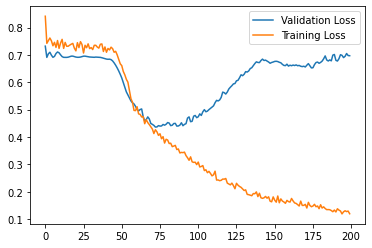

In [8]:
import matplotlib.pyplot as plt
trainloss = history.history['loss']
valloss = history.history['val_loss']
plt.plot(valloss)
plt.plot(trainloss)
plt.legend(['Validation Loss','Training Loss'])
plt.show()

In [9]:
model.metrics_names

['loss', 'accuracy']

In [10]:
model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)

3/3 [==============================] - 0s 30ms/step - loss: 0.6972 - accuracy: 0.8000


[0.6971546411514282, 0.800000011920929]

In [11]:
model.save('persian-sentiment-fasttext.model')

INFO:tensorflow:Assets written to: persian-sentiment-fasttext.model/assets


# Step D) A simple form to test our tiny shiny model 🤩
there is two form but it's just for showcase there is no diff between them.

In [16]:
user_text = "\u062E\u06CC\u0644\u06CC \u06AF\u0648\u0634\u06CC\u0647 \u062E\u0648\u0628\u06CC\u0647. \u062A\u0634\u062E\u06CC\u0635 \u0686\u0647\u0631\u0647 \u062F\u0627\u0631\u0647. \u062F\u0627\u062E\u0644 \u062C\u0639\u0628\u0647 \u06A9\u0627\u0648\u0631 \u06AF\u0648\u0634\u06CC \u0648 \u0645\u062D\u0627\u0641\u0638 \u0635\u0641\u062D\u0647 \u062F\u0627\u0631\u0647. \u0645\u0646 \u062F\u06CC\u0631\u0648\u0632 \u0628\u0647 \u062F\u0633\u062A\u0645 \u0631\u0633\u06CC\u062F\u0647 \u0639\u0627\u0644\u06CC\u0647 \u0645\u0631\u0633\u06CC \u0627\u0632 \u062F\u06CC\u062C\u06CC \u06A9\u0627\u0644\u0627" #@param {type:"string"}
from IPython.core.display import display, HTML
_normalizer = hazm.Normalizer()
if not user_text=="":
  text_for_test = _normalizer.normalize(user_text)
  text_for_test_words = hazm.word_tokenize(text_for_test)
  x_text_for_test_words = np.zeros((1,max_no_tokens,vector_size),dtype=K.floatx())
  for t in range(0,len(text_for_test_words)):
    if t >= max_no_tokens:
      break
    if text_for_test_words[t] not in w2v_model.words:
      continue
    
    x_text_for_test_words[0, t, :] = w2v_model.get_word_vector(text_for_test_words[t])
  # print(x_text_for_test_words.shape)
  # print(text_for_test_words)
  result = model.predict(x_text_for_test_words)
  pos_percent = str(int(result[0][1]*100))+" % "
  neg_percent = str(int(result[0][0]*100))+" % "
  display(HTML("<div style='text-align: center'><div style='display:inline-block'><img height='64px' width='64px' src='https://img.icons8.com/external-tulpahn-outline-color-tulpahn/64/000000/external-sad-emotion-tulpahn-outline-color-tulpahn-1.png'/><h4>{}</h4></div> | <div style='display:inline-block'><img height='64px' width='64px' src='https://img.icons8.com/external-tulpahn-outline-color-tulpahn/64/000000/external-happy-emotion-tulpahn-outline-color-tulpahn.png'/><h4>{}</h4></div></div>".format(neg_percent,pos_percent)))
else:
  print("Please enter your text")

In [17]:
user_text = "\u062E\u06CC\u0644\u06CC \u062C\u0627\u0644\u0628\u0647 \u0627\u06CC\u0646 \u0645\u0648\u0628\u0627\u06CC\u0644 \u0627\u0635\u0644\u0627 \u0647\u0645\u0647 \u0686\u06CC \u062A\u0645\u0627\u0645\u0647 \u0645\u0646 \u06A9\u0647 \u067E\u0633\u0646\u062F\u06CC\u062F\u0645 \u0627\u06CC\u0646 \u0645\u0648\u0628\u0627\u06CC\u0644 \u0632\u06CC\u0628\u0627 \u0631\u0648" #@param {type:"string"}
from IPython.core.display import display, HTML
_normalizer = hazm.Normalizer()
if not user_text=="":
  text_for_test = _normalizer.normalize(user_text)
  text_for_test_words = hazm.word_tokenize(text_for_test)
  x_text_for_test_words = np.zeros((1,max_no_tokens,vector_size),dtype=K.floatx())
  for t in range(0,len(text_for_test_words)):
    if t >= max_no_tokens:
      break
    if text_for_test_words[t] not in w2v_model.words:
      continue
    
    x_text_for_test_words[0, t, :] = w2v_model.get_word_vector(text_for_test_words[t])
  # print(x_text_for_test_words.shape)
  # print(text_for_test_words)
  result = model.predict(x_text_for_test_words)
  pos_percent = str(int(result[0][1]*100))+" % "
  neg_percent = str(int(result[0][0]*100))+" % "
  display(HTML("<div style='text-align: center'><div style='display:inline-block'><img height='64px' width='64px' src='https://img.icons8.com/external-tulpahn-outline-color-tulpahn/64/000000/external-sad-emotion-tulpahn-outline-color-tulpahn-1.png'/><h4>{}</h4></div> | <div style='display:inline-block'><img height='64px' width='64px' src='https://img.icons8.com/external-tulpahn-outline-color-tulpahn/64/000000/external-happy-emotion-tulpahn-outline-color-tulpahn.png'/><h4>{}</h4></div></div>".format(neg_percent,pos_percent)))
else:
  print("Please enter your text")